# 0. Libraries

In [1]:
# Pandas tools
import pandas as pd
import pandas as pd
import pandas.io.sql as sqlio
from pandas import DataFrame

# Database-related tools
import duckdb
import psycopg2
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT
from sqlalchemy import create_engine, text, inspect
from sqlalchemy.orm import sessionmaker

# Other utilities
import os
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# 1. Connection to the databases (including the data warehouse) and the .csv

## a. External data sources

Connection or extraction to the provided data sources. 

In [2]:
# Connection to the AIMS and AMOS databases
if 'aims' in globals():
  aims.close()
aims = psycopg2.connect(database='aims', user='bse_airlines', host='dtim.essi.upc.edu', password='BSE2024!', options='-c search_path=bda-aims')
cursor_aims = aims.cursor()
if 'amos' in globals():
  amos.close()
amos = psycopg2.connect(database='amos', user='bse_airlines', host='dtim.essi.upc.edu', password='BSE2024!', options='-c search_path=bda-amos')
cursor_amos = amos.cursor()

# Reading the .csv (must ensure that it is in the same working directory as this notebook)
df_manufacturer_lookup = pd.read_csv('aircraft-manufaturerinfo-lookup.csv')

## b. Creation and connection to the data warehouse

Creation of the data warehouse (ROLAP) using the SQL scripts in the `tables_dw` folder. Note that the code below creates a new database for the specified user. UML of the data warehouse (as a reference):

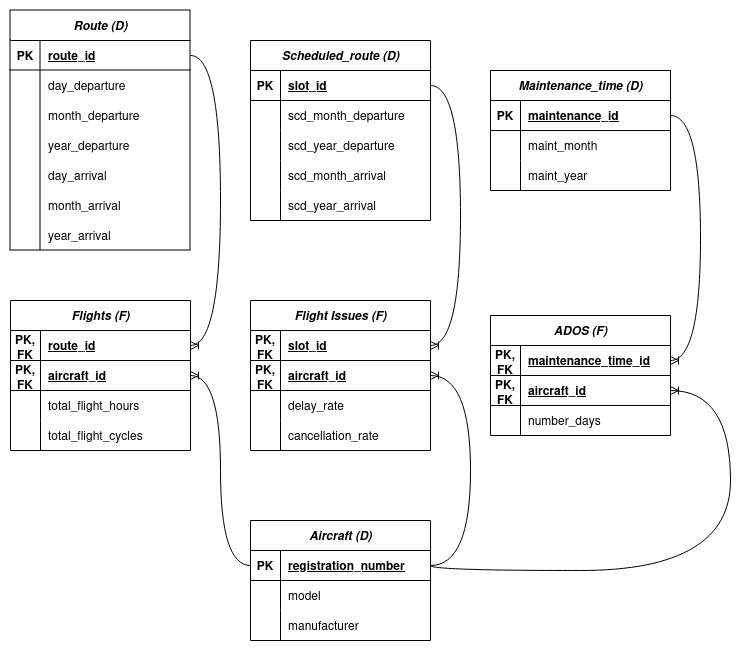
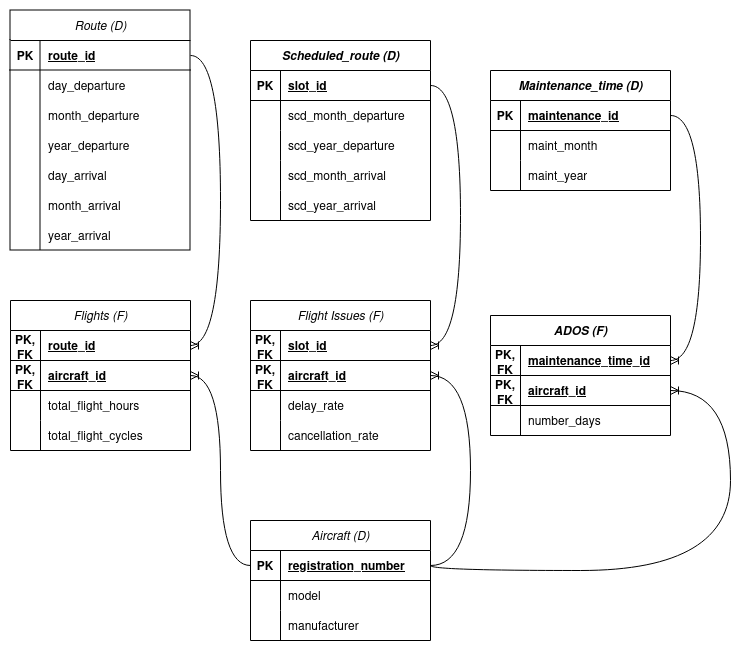
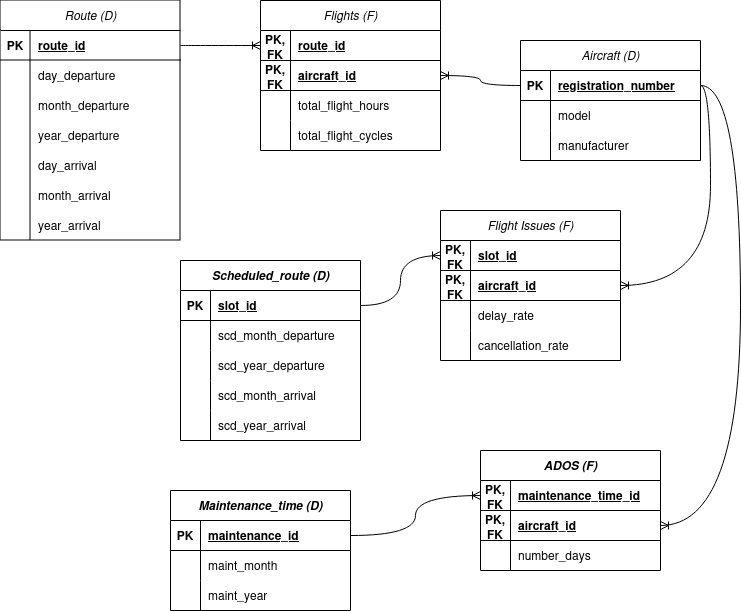

Functions to create the database and the tables of the data warehouse:

In [3]:
# Database connection parameters
DB_NAME = "lab3_dw_delgado_fernandez"
DB_USER = "postgres"    # Adjust as necessary
DB_PASSWORD = "datamg"    # Adjust as necessary
DB_HOST = "localhost"    # Adjust as necessary
DB_PORT = "5432"    # Adjust as necessary

# Function to drop and recreate the database
def recreate_database():
    try:
        # Connect to the default 'postgres' database
        connection = psycopg2.connect(
            dbname="postgres", 
            user=DB_USER, 
            password=DB_PASSWORD, 
            host=DB_HOST, 
            port=DB_PORT
        )
        connection.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)
        cursor = connection.cursor()

        # Drop the database if it exists
        cursor.execute(f"SELECT pg_terminate_backend(pg_stat_activity.pid) "
                       f"FROM pg_stat_activity WHERE pg_stat_activity.datname = '{DB_NAME}';")
        cursor.execute(f"DROP DATABASE IF EXISTS {DB_NAME};")
        print(f"Database '{DB_NAME}' dropped successfully (if it existed).")

        # Create the new database
        cursor.execute(f"CREATE DATABASE {DB_NAME};")
        print(f"Database '{DB_NAME}' created successfully.")

        # Close the connection
        cursor.close()
        connection.close()
    except Exception as e:
        print(f"Error recreating database: {e}")

# Function to execute an SQL file
def execute_sql_file(file_path, engine):
    with open(file_path, 'r') as file:
        sql_code = file.read()
        with engine.connect() as connection:
            try:
                connection.execute(text(sql_code))
                connection.commit()  # Commit the transaction
                print(f"Executed SQL file: {file_path}")
            except Exception as e:
                print(f"Error executing {file_path}: {e}")

# Function to drop all tables in the database
def drop_all_tables(engine):
    inspector = inspect(engine)
    with engine.connect() as connection:
        transaction = connection.begin()
        try:
            for table_name in inspector.get_table_names():
                connection.execute(text(f"DROP TABLE IF EXISTS {table_name} CASCADE"))
            transaction.commit()
            print("Dropped all existing tables.")
        except Exception as e:
            transaction.rollback()
            print(f"Error dropping tables: {e}")

# Function to create tables
def create_tables(engine):
    directory = 'tables_dw'  # Directory containing SQL files
    files_path = sorted([os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.sql')])

    for file_path in files_path:
        execute_sql_file(file_path, engine)

Executing the functions for creating the database and the tables for the data warehouse:

In [4]:
if __name__ == "__main__":
    # Step 1: Recreate the database (i.e., drop preexisting DB with the same name 
    # and create a new one)
    recreate_database()

    # Step 2: Connect to the newly created database
    DATABASE_URL = f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
    engine = create_engine(DATABASE_URL)

    # Step 3: Drop all tables and create new ones
    drop_all_tables(engine)
    create_tables(engine)

    # Step 4: Close connection to the database
    engine.dispose()
    print("Database connection closed successfully.")

Database 'lab3_dw_delgado_fernandez' dropped successfully (if it existed).
Database 'lab3_dw_delgado_fernandez' created successfully.
Dropped all existing tables.
Executed SQL file: tables_dw/01_Route.sql
Executed SQL file: tables_dw/02_Aircraft.sql
Executed SQL file: tables_dw/03_Flights.sql
Executed SQL file: tables_dw/04_Scheduled_routes.sql
Executed SQL file: tables_dw/05_Flight_Issues.sql
Executed SQL file: tables_dw/06_Maintenance_time.sql
Executed SQL file: tables_dw/07_ADOS.sql
Database connection closed successfully.


In [5]:
# Connect to the newly created database through psycopg2 (for consistency)
if DB_NAME in globals():
    DB_NAME.close()
dw = psycopg2.connect(database=DB_NAME, user=DB_USER, host=DB_HOST, password=DB_PASSWORD)
# Create a cursor
cursor_dw = dw.cursor()

# 2. ETL process

## 2.1. Extracting the necessary data from AIMS, AMOS and the aircraft manufacturer lookup (.csv)

For answering the user analytical requirements *R1* and *R2* and filling the data warehouse with meaningful data, we have found it relevant to extract the following data from the data inputs:
- First, the actual times of departure and arrival of the flights (*actualDeparture* and *actualArrival*, from the relation *Flights* of the database AIMS). We will use these timestamps to extract the day, month and year of a certain flight. In turn, this information will then be used for knowing the total flight hours and cycles per aircraft, day, month and year. Only values previous to the current date should be included, and we will check that there were no flights that happened at the same time as maintenance events (which would be inconsistent).
- Second, the *aircraftRegistration* number from the *Flights* relation of the database AIMS, as the flightID is created such that it includes the registration number: `flightID CHAR(26) NOT NULL, -- Date-Origin-Destination-FlightNumber-AircraftRegistration -> 6+1+3+1+3+1+4+1+6` (taken from the SQL file of the creation of AIMS). However, we will check for consistency between this number and the registration number appearing in the relation *Slots* of the database AIMS (as *aircraftRegistration*).
- Third, from the csv we will extract the model and manufacturer for each registration number.
- Fourth, for the requirement R2, we will extract the scheduled time for a flight, which is in the relation *Slots* in the database AIMS (but since *Flights* inherits from *Slots*, *Flights* will suffice for the facts "delay rate" and "cancellation rate").
- Fifth, we will use the boolean *cancelled* and the *delayCode* ("IATA code" of the delay) for computing the rates of flights that have been either delayed or cancelled (including flights that are scheduled for the future). Basically, null delay codes are flights which have operated on schedule, while those with a non-null delay codes have been delayed ([general reference of IATA delay codes](https://en.wikipedia.org/wiki/IATA_delay_codes), [list of codes](https://ansperformance.eu/library/iata-delay-codes.pdf)).
- Sixth, the times of maintenance events (the start time and the duration), which will be used to know the days an aircraft was out of service.

### a. AIMS

In [6]:
# Extract fields of interest from the Flights table, which inherits from Slots - AIMS

Q_flights = "SELECT aircraftregistration, flightid, scheduleddeparture, scheduledarrival, actualdeparture, actualarrival, cancelled, delaycode FROM Flights;"

df_flights = sqlio.read_sql_query(Q_flights, aims)

df_flights.head(10)

,aircraftregistration,flightid,scheduleddeparture,scheduledarrival,actualdeparture,actualarrival,cancelled,delaycode
0,XY-RJL,230803-NRN-JMK-9129-XY-RJL,2023-08-03 11:03:03.875940,2023-08-03 14:03:03.875940,NaT,NaT,True,None
1,XY-OZE,230726-HAU-SAW-9867-XY-OZE,2023-07-26 14:50:15.569812,2023-07-26 15:50:15.569812,NaT,NaT,True,None
2,XY-SJZ,231120-HER-VAA-6975-XY-SJZ,2023-11-20 09:01:04.308766,2023-11-20 13:01:04.308766,NaT,NaT,True,None
3,XY-OXK,230613-VNO-EGC-9468-XY-OXK,2023-06-13 09:55:02.480695,2023-06-13 11:55:02.480695,NaT,NaT,True,None
4,XY-DGU,230312-BLL-BVA-9815-XY-DGU,2023-03-12 00:41:45.198279,2023-03-12 03:41:45.198279,NaT,NaT,True,None
5,XY-CMS,230927-vKo-lUg-5629-XY-CMS,2023-09-27 04:16:33.946201,2023-09-27 05:16:33.946201,NaT,NaT,True,None
6,XY-RJM,230106-ESB-SXF-1266-XY-RJM,2023-01-06 21:23:48.860304,2023-01-07 02:23:48.860304,NaT,NaT,True,None
7,XY-LKU,230730-BHX-BDS-3846-XY-LKU,2023-07-30 13:40:52.793055,2023-07-30 18:40:52.793055,NaT,NaT,True,None
8,XY-CRS,230103-GVA-GDN-4559-XY-CRS,2023-01-03 03:52:12.278595,2023-01-03 04:52:12.278595,NaT,NaT,True,None
9,XY-IVJ,230125-Gva-led-1268-XY-IVJ,2023-01-25 16:50:39.680743,2023-01-25 18:50:39.680743,NaT,NaT,True,None


In [ ]:
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151833 entries, 0 to 151832
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   aircraftregistration  151833 non-null  object        
 1   flightid              151833 non-null  object        
 2   scheduleddeparture    151833 non-null  datetime64[ns]
 3   scheduledarrival      151833 non-null  datetime64[ns]
 4   actualdeparture       141792 non-null  datetime64[ns]
 5   actualarrival         141792 non-null  datetime64[ns]
 6   cancelled             151833 non-null  bool          
 7   delaycode             14166 non-null   object        
dtypes: bool(1), datetime64[ns](4), object(3)
memory usage: 8.3+ MB


In [20]:
# Extract fields of interest from the Maintenance table, which inherits from Slots - AIMS
# This can be useful for checking consistency and duplicities

Q_maint_aims = "SELECT aircraftregistration, scheduleddeparture, scheduledarrival FROM Maintenance;"

df_maint_aims = sqlio.read_sql_query(Q_maint_aims, aims)

df_maint_aims.head(10)

,aircraftregistration,scheduleddeparture,scheduledarrival
0,XY-AAB,2023-01-01 12:16:40.291989,2023-01-01 15:16:40.291989
1,XY-AAB,2023-01-01 18:04:56.231015,2023-01-01 19:04:56.231015
2,XY-AAB,2023-01-03 22:24:03.213203,2023-01-03 23:24:03.213203
3,XY-AAB,2023-01-04 11:34:31.530886,2023-01-04 11:34:31.530886
4,XY-AAB,2023-01-04 17:21:00.599109,2023-01-04 19:21:00.599109
5,XY-AAB,2023-01-05 09:21:57.443837,2023-01-05 10:21:57.443837
6,XY-AAB,2023-01-07 11:48:20.469456,2023-01-07 15:48:20.469456
7,XY-AAB,2023-01-09 06:51:42.989543,2023-01-09 08:51:42.989543
8,XY-AAB,2023-01-11 18:41:10.390991,2023-01-11 20:41:10.390991
9,XY-AAB,2023-01-13 09:07:12.945785,2023-01-13 12:07:12.945785


In [35]:
df_maint_aims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74743 entries, 0 to 74742
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   aircraftregistration  74743 non-null  object        
 1   scheduleddeparture    74743 non-null  datetime64[ns]
 2   scheduledarrival      74743 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(1)
memory usage: 1.7+ MB


### b. AMOS

In [8]:
# Extract fields of interest from the Maintenance table - AMOS
# This can be useful for checking consistency and duplicities

Q_maint_ev = "SELECT maintenanceid, aircraftregistration, starttime, duration FROM MaintenanceEvents;"

df_maint_ev = sqlio.read_sql_query(Q_maint_ev, amos)

df_maint_ev.head(10)

,maintenanceid,aircraftregistration,starttime,duration
0,24167,XY-AAB,2023-01-01 12:16:40.291989,0 days 03:00:00
1,24168,XY-AAB,2023-01-01 18:04:56.231015,0 days 01:00:00
2,24169,XY-AAB,2023-01-03 22:24:03.213203,0 days 01:00:00
3,24170,XY-AAB,2023-01-04 11:34:31.530886,0 days 00:00:00
4,24171,XY-AAB,2023-01-04 17:21:00.599109,0 days 02:00:00
5,24172,XY-AAB,2023-01-05 09:21:57.443837,0 days 01:00:00
6,24173,XY-AAB,2023-01-07 11:48:20.469456,0 days 04:00:00
7,24174,XY-AAB,2023-01-09 06:51:42.989543,0 days 02:00:00
8,24175,XY-AAB,2023-01-11 18:41:10.390991,0 days 02:00:00
9,24176,XY-AAB,2023-01-13 09:07:12.945785,0 days 03:00:00


In [36]:
df_maint_ev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98909 entries, 0 to 98908
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype          
---  ------                --------------  -----          
 0   maintenanceid         98909 non-null  int64          
 1   aircraftregistration  98909 non-null  object         
 2   starttime             98909 non-null  datetime64[ns] 
 3   duration              98909 non-null  timedelta64[ns]
dtypes: datetime64[ns](1), int64(1), object(1), timedelta64[ns](1)
memory usage: 3.0+ MB


### c. Aircraft Manufacturer Lookup (`.csv`)

In [9]:
df_manufacturer_lookup = pd.read_csv('aircraft-manufaturerinfo-lookup.csv')

df_manufacturer_lookup.drop(columns = ['manufacturer_serial_number'], inplace = True)

df_manufacturer_lookup.head()

,aircraft_reg_code,aircraft_model,aircraft_manufacturer
0,XY-ZCK,777,Airbus
1,XY-UWV,777,Airbus
2,XY-HWJ,747,Airbus
3,XY-NIP,747,Boeing
4,XY-CMS,A319,Airbus


## 2.2. Data cleaning

### Removing duplicates
In this section, we check, separately for each extracted dataframe, whether there are unwanted duplicates in the data.

In [ ]:
print(f'Number of duplicate flights: {len(df_flights) - df_flights['flightid'].nunique()}')

Number of duplicates in the flights dataframe: 0


In [61]:
print(f'Number of duplicate maintenance events: {len(df_maint_ev) - df_maint_ev['maintenanceid'].nunique()}')

Number of duplicate maintenance events: 0


In [62]:
print(f'Number of duplicate aircrafts: {len(df_manufacturer_lookup) - df_manufacturer_lookup['aircraft_reg_code'].nunique()}')

Number of duplicate aircrafts: 0


### Removing or imputing (non-desired) nulls
In this section, we check the consistency of the existing null values in the instances of the database and assess its treatment.

In [63]:
def check_nulls(df):
    # Count of null values per column
    df_tr_na = df.isnull().sum()
    # Filter only columns with missing values
    missing_values_tr = df_tr_na[df_tr_na > 0]
    # Compute percentage of missing values
    missing_values_percentage = (missing_values_tr / len(df)) * 100
    # Display the result
    print("Columns with missing values:")
    print(missing_values_tr)
    print("\nPercentage of missing values:")
    print(missing_values_percentage)

In [ ]:
check_nulls(df_flights)

Columns with missing values:
actualdeparture     10041
actualarrival       10041
delaycode          137667
dtype: int64

Percentage of missing values:
actualdeparture     6.613187
actualarrival       6.613187
delaycode          90.670012
dtype: float64


In the flights table, there are missing values in the actual departure and arrival times (which is consistent with the fact that some flights may not have happened yet) and in the delay code (which is consistent as well for flights that have not been delayed). Therefore, there is no need to remove or to impute nulls.

In [65]:
check_nulls(df_maint_ev)

Columns with missing values:
Series([], dtype: int64)

Percentage of missing values:
Series([], dtype: float64)


In [66]:
check_nulls(df_manufacturer_lookup)

Columns with missing values:
Series([], dtype: int64)

Percentage of missing values:
Series([], dtype: float64)


### Checking domain constraints
In this section, we check some domain-specific constraints that may introduce a bias in the user analytical requirements. Specifically, we check that:
1. Scheduled flight departure time is always before the scheduled flight arrival time.
2. Duration of each maintenance event is always non-negative.
3. Aircrafts that have been assigned to flights are all registered (i.e., are in the lookup table).
4. The same aircraft is not assigned to a flight and to maintenance at the same time.
5. Flights that have been cancelled do not have an actual departure and arrival time.
6. Flights that have been delayed have a different actual departure time from the scheduled time.

#### 1. Scheduled flight departure time is always before the scheduled flight arrival time.

In [10]:
# Time delta for the schedule
df_flights['diff_scheduled_arr-dep'] = df_flights['scheduledarrival'] - df_flights['scheduleddeparture']
# Time delta for the actual departure and arrival
df_flights['diff_actual_arr-dep'] = df_flights['actualarrival'] - df_flights['actualdeparture']
# Show the flights dataframe, sorted by the time delta in the scheduled departures-arrivals
df_flights.sort_values(by = 'diff_scheduled_arr-dep', ascending = True).head()

,aircraftregistration,flightid,scheduleddeparture,scheduledarrival,actualdeparture,actualarrival,cancelled,delaycode,diff_scheduled_arr-dep,diff_actual_arr-dep
94884,XY-OYK,231031-LbA-tFn-1671-XY-OYK,2023-10-31 14:25:10.652754,2023-10-31 14:25:10.652754,2023-10-31 14:39:10.652754,2023-10-31 14:39:10.652754,False,None,0 days,0 days
108000,XY-RQO,230311-MPL-TBS-8361-XY-RQO,2023-03-11 04:39:03.225015,2023-03-11 04:39:03.225015,2023-03-11 04:44:03.225015,2023-03-11 04:44:03.225015,False,None,0 days,0 days
107976,XY-RQO,230217-bmA-ztH-4942-XY-RQO,2023-02-17 09:31:19.357030,2023-02-17 09:31:19.357030,2023-02-17 09:39:19.357030,2023-02-17 09:39:19.357030,False,None,0 days,0 days
6872,XY-TIH,230801-FNc-Cwl-9351-XY-TIH,2023-08-01 20:52:12.179444,2023-08-01 20:52:12.179444,NaT,NaT,True,None,0 days,NaT
38290,XY-EWI,230711-ISt-tSe-9526-XY-EWI,2023-07-11 00:05:11.314626,2023-07-11 00:05:11.314626,2023-07-11 00:14:11.314626,2023-07-11 00:14:11.314626,False,None,0 days,0 days


It seems that there are some flights which have not been cancelled or delayed for which the scheduled departure time coincides with the scheduled arrival time, and the same happens for the actual times: for now, we will flag those flights with an additional column, for facilitating the possibility of dropping in the futurer those instances. 

In [11]:
# Inconsistent schedule
df_flights['inconsistent_schedule'] = (
    (df_flights['diff_scheduled_arr-dep'] <= pd.Timedelta("0 days 00:00:00")) & 
    (df_flights['cancelled'] == False)
)

# Inconsistent actual flights
df_flights['inconsistent_actual'] = (
    (df_flights['diff_actual_arr-dep'] <= pd.Timedelta("0 days 00:00:00")) & 
    (df_flights['cancelled'] == False)
)

# Show the flights dataframe, sorted by the time delta in the scheduled departures-arrivals
df_flights.sort_values(by = 'diff_scheduled_arr-dep', ascending = True).head()

,aircraftregistration,flightid,scheduleddeparture,scheduledarrival,actualdeparture,actualarrival,cancelled,delaycode,diff_scheduled_arr-dep,diff_actual_arr-dep,inconsistent_schedule,inconsistent_actual
94884,XY-OYK,231031-LbA-tFn-1671-XY-OYK,2023-10-31 14:25:10.652754,2023-10-31 14:25:10.652754,2023-10-31 14:39:10.652754,2023-10-31 14:39:10.652754,False,None,0 days,0 days,True,True
108000,XY-RQO,230311-MPL-TBS-8361-XY-RQO,2023-03-11 04:39:03.225015,2023-03-11 04:39:03.225015,2023-03-11 04:44:03.225015,2023-03-11 04:44:03.225015,False,None,0 days,0 days,True,True
107976,XY-RQO,230217-bmA-ztH-4942-XY-RQO,2023-02-17 09:31:19.357030,2023-02-17 09:31:19.357030,2023-02-17 09:39:19.357030,2023-02-17 09:39:19.357030,False,None,0 days,0 days,True,True
6872,XY-TIH,230801-FNc-Cwl-9351-XY-TIH,2023-08-01 20:52:12.179444,2023-08-01 20:52:12.179444,NaT,NaT,True,None,0 days,NaT,False,False
38290,XY-EWI,230711-ISt-tSe-9526-XY-EWI,2023-07-11 00:05:11.314626,2023-07-11 00:05:11.314626,2023-07-11 00:14:11.314626,2023-07-11 00:14:11.314626,False,None,0 days,0 days,True,True


This result has the intended purpose: it flags with `True` those flights for which the scheduled or actual departure time matches the scheduled or actual arrival time, for flights that have *not* been cancelled. In the end, those flights should not be taken into account for computing the total flight hours, cycles and delay and cancellation rates.

#### 2. Duration of each maintenance event is always non-negative

In [14]:
if len(df_maint_ev[df_maint_ev['duration'] < pd.Timedelta("0 days 00:00:00")]) > 0:
    print('There are maintenance events of negative duration, which should be removed.')
else:
    print('There are no negative maintenance events, so the data is (in this regard) consistent.')

There are no negative maintenance events, so the data is (in this regard) consistent.


#### 3. Aircrafts that have been assigned to flights are all registered

In [18]:
df_join = df_flights.merge(right = df_manufacturer_lookup, how = 'inner', left_on='aircraftregistration', right_on='aircraft_reg_code')

# Since we have done an inner join, if all the aircrafts that are assigned to flights
# are registered, the length of both data frames should be the same
if len(df_join) < len(df_flights):
    print('There are some non-registered aircrafts that are assigned to flights.')
else:
    print('All aircrafts assigned to flights are registered.')

# We delete the data frame that has been used for this check
del df_join

All aircrafts assigned to flights are registered.


#### 4. The same aircraft is not assigned to a flight and to maintenance at the same time
In this case, we can do 2 different checks: one for the *Maintenance* table, seeing if there are Flights and Maintenances in conflict, and another for the *MaintenanceEvents* table.

#### 5. Flights that have been cancelled do not have an actual departure and arrival time

In [35]:
cancelled_flights = df_flights[df_flights['cancelled'] == True]
number_cancelled_flights = len(cancelled_flights)
number_null_departure_cancelled_flights = cancelled_flights['actualdeparture'].isna().sum()

# We check if the number of cancelled flights matches with the number of cancelled
# flights with a null departure time (otherwise, there will be an inconsistency)
if number_cancelled_flights != number_null_departure_cancelled_flights:
    print('There are some flights that have been cancelled that have an actual departure time.')
else:
    print('All flights that have been cancelled do not have an actual departure time.')

All flights that have been cancelled do not have an actual departure time.


#### 6. Flights that have been delayed have a different actual departure time

In [ ]:
#

## 2.3. Integrate data

## 2.4. Calculation of measures

## 2.5. Loading the data into the data warehouse

In [41]:
data = {
    'maintenance_id': [101, 102, 103, 104, 105],
    'maint_month': [1, 2, 3, 4, 5],
    'maint_year': [2024, 2024, 2024, 2024, 2024]
}

df = pd.DataFrame(data)

In [50]:
# Insert data into the 'Flights' table
for index, row in df.iterrows():
    cursor_dw.execute("""
        INSERT INTO maintenance_time (maintenance_id, maint_month, maint_year) 
        VALUES (%s, %s, %s)
        """, (int(row['maintenance_id']), int(row['maint_month']), int(row['maint_year'])))

# Commit the changes and close the connection
dw.commit()
cursor_dw.close()

## Explore the AIMS data source (cursor)

Here you can run differnet queries in order to explore the database tables, their columns and the values stored inside.
In this case, we load the result set of our SQL query into a cursor object over which we can iterate in order to obtain its values.

In [ ]:
#Write any query you want to explore the database!
# limit X is used to reduce the output to only top X rows. Useful in the case of large DB tables.

Q1 = "SELECT * FROM Flights limit 10;"

# Creatingo a cursor and executing a query (DO NOT MODIFY!)
cursor = aims.cursor()
cursor.execute(Q1)
result = cursor.fetchall()
# printing out the results
for row in result:
    print(row)

cursor.close()

(1, 'XY-RJL', datetime.datetime(2023, 8, 3, 11, 3, 3, 875940), datetime.datetime(2023, 8, 3, 14, 3, 3, 875940), 'Flight         ', '230803-NRN-JMK-9129-XY-RJL', 'NRN', 'JMK', None, None, True, None, 98, 3, 2)
(2, 'XY-OZE', datetime.datetime(2023, 7, 26, 14, 50, 15, 569812), datetime.datetime(2023, 7, 26, 15, 50, 15, 569812), 'Flight         ', '230726-HAU-SAW-9867-XY-OZE', 'HAU', 'SAW', None, None, True, None, 107, 4, 3)
(3, 'XY-SJZ', datetime.datetime(2023, 11, 20, 9, 1, 4, 308766), datetime.datetime(2023, 11, 20, 13, 1, 4, 308766), 'Flight         ', '231120-HER-VAA-6975-XY-SJZ', 'HER', 'VAA', None, None, True, None, 137, 3, 2)
(4, 'XY-OXK', datetime.datetime(2023, 6, 13, 9, 55, 2, 480695), datetime.datetime(2023, 6, 13, 11, 55, 2, 480695), 'Flight         ', '230613-VNO-EGC-9468-XY-OXK', 'VNO', 'EGC', None, None, True, None, 102, 4, 2)
(5, 'XY-DGU', datetime.datetime(2023, 3, 12, 0, 41, 45, 198279), datetime.datetime(2023, 3, 12, 3, 41, 45, 198279), 'Flight         ', '230312-BLL-BV

## Join data frames

Here we can join WorkOrders data frame with the Aircraft lookup dataframe and add new columns like aircraft model and manufacturer to the WorkOrders data frame.

For this purpose we can use either **join** or **merge** operation in Pandas.  

Join operation requires setting up the indexes of the data frames using the keys on which we want to do join.
More info on join operation in Pandas: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html

Merge operation can perform joins using any specified column of the data frame. *Here we use a merge operation* and join the two data frames of the **aircraftregistration** and **aircraft_reg_code**
More info on merge operation in Pandas: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html


In [ ]:
dfJoin = dfWO.merge(dfAircrafts, left_on='aircraftregistration', right_on='aircraft_reg_code')


dfJoin.head(1000)

,workorderid,aircraftregistration,executiondate,executionplace,workpackage,kind,aircraft_reg_code,manufacturer_serial_number,aircraft_model,aircraft_manufacturer
0,2,XY-AAB,2023-01-01,FAO,1.0,Forecast,XY-AAB,MSN 9818,767,Boeing
1,3,XY-AAB,2023-01-01,FAO,1.0,Forecast,XY-AAB,MSN 9818,767,Boeing
2,10,XY-AAB,2023-01-04,MUC,4.0,Forecast,XY-AAB,MSN 9818,767,Boeing
3,11,XY-AAB,2023-01-04,MUC,4.0,Forecast,XY-AAB,MSN 9818,767,Boeing
4,14,XY-AAB,2023-01-05,BJV,NaN,Forecast,XY-AAB,MSN 9818,767,Boeing
5,16,XY-AAB,2023-01-07,AJA,5.0,Forecast,XY-AAB,MSN 9818,767,Boeing
6,18,XY-AAB,2023-01-09,BRE,NaN,Forecast,XY-AAB,MSN 9818,767,Boeing
7,22,XY-AAB,2023-01-14,bhD,7.0,Forecast,XY-AAB,MSN 9818,767,Boeing
8,23,XY-AAB,2023-01-14,bhD,7.0,Forecast,XY-AAB,MSN 9818,767,Boeing
9,32,XY-AAB,2023-01-17,ZTH,11.0,Forecast,XY-AAB,MSN 9818,767,Boeing


# 3. Closing the connection with the AIMS and AMOS database

In [ ]:
aims.close()
amos.close()

NameError: name 'aims' is not defined